In [2]:
# !pip install mlxtend
# !pip install onnxmltools
# !pip install onnxruntime

In [3]:
import numpy as np
import torch
import pandas as pd
import sklearn
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
import matplotlib.pyplot as plt

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

 
from sklearn.metrics import r2_score

In [5]:
import onnxruntime as rt
import onnxmltools

In [6]:
batch_size    = 16
learning_rate = 0.005 ## 0.001
N_Epochs      = 100

epsilon = 0.0001

In [7]:
path_data = 'winequality-red.csv' # path to the data

WINE_raw_data = pd.read_csv( path_data, delimiter=";" ) # Reading red wine data

In [8]:
WINE_raw_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [9]:
headers_list = WINE_raw_data.columns.values.tolist()

headers_list # Types of features/headers

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [10]:
headers_list2 = [ 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

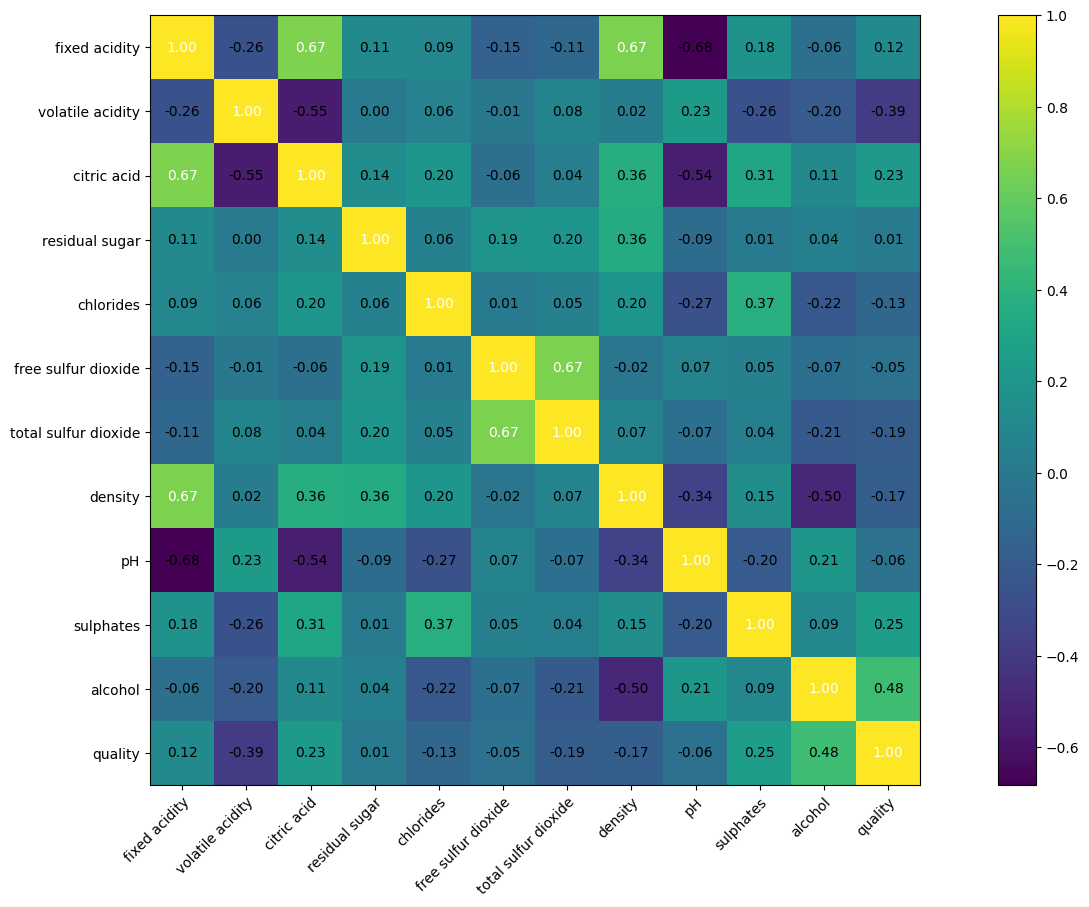

In [11]:
cm = np.corrcoef(   WINE_raw_data[headers_list].values.T   )
hm = heatmap(cm, row_names=headers_list, column_names=headers_list, figsize=(20,10))
plt.show() # Show graph of x and y axis data structure

In [12]:
WINE_raw_data_np = WINE_raw_data.to_numpy()

In [13]:
WINE_raw_data_np

array([[ 7.4  ,  0.7  ,  0.   , ...,  0.56 ,  9.4  ,  5.   ],
       [ 7.8  ,  0.88 ,  0.   , ...,  0.68 ,  9.8  ,  5.   ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  0.65 ,  9.8  ,  5.   ],
       ...,
       [ 6.3  ,  0.51 ,  0.13 , ...,  0.75 , 11.   ,  6.   ],
       [ 5.9  ,  0.645,  0.12 , ...,  0.71 , 10.2  ,  5.   ],
       [ 6.   ,  0.31 ,  0.47 , ...,  0.66 , 11.   ,  6.   ]],
      shape=(1599, 12))

In [14]:
WINE_raw_data_np.shape

(1599, 12)

In [15]:
X = WINE_raw_data_np[:, :-1]


y = WINE_raw_data_np[:, 5:6]

In [16]:
print(X.shape)

print(y.shape)

(1599, 11)
(1599, 1)


In [17]:
random_seed = int( random.random() * 100 )     

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=random_seed) # Start training

In [63]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15, 11)
(1584, 11)
(15, 1)
(1584, 1)


In [64]:
y_test.dtype 

dtype('float64')

In [65]:
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test  = y_test.astype(np.float32)

In [66]:
X_train_tr = torch.from_numpy(X_train)
X_test_tr  = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr  = torch.from_numpy(y_test)

In [67]:
x_means      = X_train_tr.mean(0, keepdim=True ) 
x_deviations = X_train_tr.std( 0, keepdim=True) + epsilon

In [68]:
x_means # Tensor operations

tensor([[ 8.8133,  0.4520,  0.3647,  2.4133,  0.0915, 12.0667, 46.3333,  0.9968,
          3.2827,  0.6840, 10.6400]])

In [69]:
x_deviations

tensor([[2.1916e+00, 1.3104e-01, 2.2456e-01, 1.1489e+00, 3.9421e-02, 7.6390e+00,
         3.4434e+01, 2.4717e-03, 1.4821e-01, 9.8211e-02, 1.4847e+00]])

In [70]:
train_ds = TensorDataset( X_train_tr, y_train_tr  )

In [71]:
train_dl = DataLoader( train_ds, batch_size, shuffle=True  )

In [72]:
train_dl

In [73]:
class LinRegNet(nn.Module):
    
    def __init__(self, x_means, x_deviations):
        super().__init__()
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.linear1 = nn.Linear(11, 1)
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        y_pred = self.linear1(x) # This is the prediction from its operation
        return y_pred

In [74]:
class MLP_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super().__init__()
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.linear1 = nn.Linear(11, 8)
        self.act1    = nn.Sigmoid()
        self.linear2 = nn.Linear(8, 1) #torch.nn
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        y_pred = self.linear2(x) # Sum operations
        return y_pred

In [75]:
class DL_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(11, 10)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        y_pred = self.linear3(x)
        return y_pred

In [76]:
class LinearPlusNonLinear_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super().__init__()  
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.f1_linear1 = nn.Linear(11, 1) # f1 score
        self.f2_linear1 = nn.Linear(11, 14) # f2 score
        self.f2_act1    = nn.Sigmoid()
        self.f2_linear2 = nn.Linear(14, 1)
    def forward(self, x):
        x = (x-self.x_means) / self.x_deviations
        f1 = self.f1_linear(x)
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_linear2(f2)
        y_pred = f1 + f2
        return y_pred # f1 and f2 prediction

In [77]:
def training_loop(N_Epochs, model, loss_fn,opt):
    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            y_pred = model(xb) # Prediction model
            loss   = loss_fn(y_pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
        if epoch % 20 == 0:
            print(epoch, "loss =", loss)

In [ ]:
model = DL_Net(x_means, x_deviations)

opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss

training_loop(N_Epochs, model, loss_fn, opt) # Print out loss tensor function

In [79]:
y_pred_test = model(X_test_tr)

In [80]:
y_pred_test.shape

torch.Size([1584, 1])

In [81]:
print("Testing R**2: ", r2_score(  y_test_tr.numpy(),  y_pred_test.detach().numpy())) 

Testing R**2:  0.2542121410369873


In [82]:
y_pred_test.shape

torch.Size([1584, 1])

In [83]:
y_test_tr.shape

torch.Size([1584, 1])

In [84]:
len(X_test_tr)

1584

In [87]:
list_preds = []
list_reals = []

for i in range(len(X_test_tr)):
    print("xxxxxxxxxxxxxxxxxxxxxxxxx")
    print("prediction, real")
    np_real = y_test_tr[i].detach().numpy()
    np_pred = y_pred_test[i].detach().numpy()
    print((np_pred, np_real))
    list_preds.append(np_pred[0])
    list_reals.append(np_real[0])

xxxxxxxxxxxxxxxxxxxxxxxxx
prediction, real
(array([8.429576], dtype=float32), array([5.], dtype=float32))
xxxxxxxxxxxxxxxxxxxxxxxxx
prediction, real
(array([14.801109], dtype=float32), array([18.], dtype=float32))
xxxxxxxxxxxxxxxxxxxxxxxxx
prediction, real
(array([9.860608], dtype=float32), array([5.], dtype=float32))
xxxxxxxxxxxxxxxxxxxxxxxxx
prediction, real
(array([15.074537], dtype=float32), array([5.], dtype=float32))
xxxxxxxxxxxxxxxxxxxxxxxxx
prediction, real
(array([10.943311], dtype=float32), array([6.], dtype=float32))
xxxxxxxxxxxxxxxxxxxxxxxxx
prediction, real
(array([17.542986], dtype=float32), array([22.], dtype=float32))
xxxxxxxxxxxxxxxxxxxxxxxxx
prediction, real
(array([10.310535], dtype=float32), array([16.], dtype=float32))
xxxxxxxxxxxxxxxxxxxxxxxxx
prediction, real
(array([10.774455], dtype=float32), array([5.], dtype=float32))
xxxxxxxxxxxxxxxxxxxxxxxxx
prediction, real
(array([15.567349], dtype=float32), array([15.], dtype=float32))
xxxxxxxxxxxxxxxxxxxxxxxxx
predictio

In [88]:
model.eval()
dummy_input = torch.randn(1, 11)
input_names  = ["input1"]
output_names = ["output1"]
torch.onnx.export(
        model, 
        dummy_input,
        "DLnet_WineData.onnx",
        verbose=False,
        input_names = input_names,
        output_names = output_names
)